In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models,transforms
from torchvision.datasets import ImageFolder

In [2]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

# Load data

- Dataset can be downloaded [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101).

In [3]:
path = 'C:/Users/Yeonkang/Desktop/Deep_Learning/Image_Recognition/Vanilla_CNN/Python/data/101_ObjectCategories'

In [4]:
simple_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), 
                                       transforms.Normalize([0.576,0.537,0.500],[0.224,0.196,0.188])])
train = ImageFolder(os.path.join(path,'train'), simple_transform)
valid = ImageFolder(os.path.join(path,'valid'), simple_transform)

In [5]:
train_data_loader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True, num_workers=3)
valid_data_loader = torch.utils.data.DataLoader(valid, batch_size=16, shuffle=True, num_workers=3)

# Adjust ResNet18

## Change *out_features* of the last linear layer

In [6]:
resnet = models.resnet18(pretrained=True)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
resnet.fc.out_features = 101

In [8]:
def fit(epoch, model, data_loader, phase='training', volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    
    for batch_idx,(data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data,target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        running_loss += F.cross_entropy(output, target, reduction='mean').data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss.item()/len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [9]:
if is_cuda:
    resnet = resnet.cuda()

In [10]:
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
train_losses,train_accuracy = [],[]
val_losses,val_accuracy = [],[]

for epoch in range(1,10):
    train_epoch_loss,train_epoch_accuracy = fit(epoch, resnet, train_data_loader, phase='training')
    val_epoch_loss,val_epoch_accuracy = fit(epoch, resnet, valid_data_loader, phase='validation')
    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.13 and training accuracy is 4956/8000     61.95
validation loss is 0.037 and validation accuracy is 582/677     85.97
training loss is 0.022 and training accuracy is 7375/8000     92.19
validation loss is 0.022 and validation accuracy is 615/677     90.84
training loss is 0.0067 and training accuracy is 7854/8000     98.17
validation loss is 0.019 and validation accuracy is 632/677     93.35
training loss is 0.0031 and training accuracy is 7964/8000     99.55
validation loss is 0.017 and validation accuracy is 632/677     93.35
training loss is 0.002 and training accuracy is 7981/8000     99.76
validation loss is 0.016 and validation accuracy is 631/677     93.21
training loss is 0.0015 and training accuracy is 7986/8000     99.83
validation loss is 0.017 and validation accuracy is 635/677      93.8
training loss is 0.001 and training accuracy is 7990/8000     99.88
validation loss is 0.015 and validation accuracy is 636/677     93.94
training loss is 0.00091 and tr

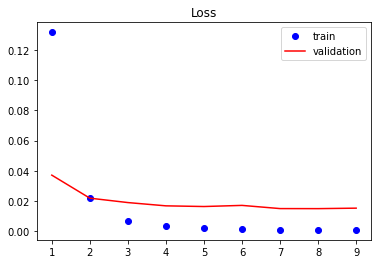

In [11]:
plt.plot(range(1,len(train_losses)+1), train_losses, 'bo', label='train')
plt.plot(range(1,len(val_losses)+1), val_losses, 'r', label='validation')
plt.title('Loss')
plt.legend()

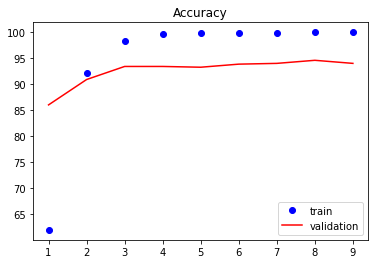

In [12]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy, 'bo', label='train')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy, 'r', label='validation')
plt.title('Accuracy')
plt.legend()

## Data Augmentation

In [13]:
aug_transform = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(),transforms.RandomRotation(0.2), 
                                    transforms.ToTensor(), transforms.Normalize([0.576,0.537,0.500],[0.224,0.196,0.188])])
train = ImageFolder(os.path.join(path,'train'), aug_transform)
valid = ImageFolder(os.path.join(path,'valid'), aug_transform)

In [14]:
train_data_loader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True, num_workers=3)
valid_data_loader = torch.utils.data.DataLoader(valid, batch_size=16, shuffle=True, num_workers=3)

In [15]:
train_losses,train_accuracy = [],[]
val_losses,val_accuracy = [],[]

for epoch in range(1,3):
    train_epoch_loss,train_epoch_accuracy = fit(epoch, resnet, train_data_loader, phase='training')
    val_epoch_loss,val_epoch_accuracy = fit(epoch, resnet, valid_data_loader, phase='validation')
    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.0095 and training accuracy is 7678/8000     95.97
validation loss is 0.019 and validation accuracy is 625/677     92.32
training loss is 0.0046 and training accuracy is 7878/8000     98.47
validation loss is 0.017 and validation accuracy is 621/677     91.73


# Visualize output from intermediate layer

## Visualizing output from intermediate layer

In [16]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=16, num_workers=3, shuffle=False)
img,label = next(iter(train_data_loader))

In [17]:
def imshow(inp):
    inp = inp.numpy().transpose((1,2,0))
    mean,std = np.array([0.576,0.537,0.500]),np.array([0.224,0.196,0.188])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)

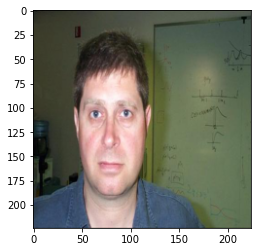

In [18]:
imshow(img[10])

In [19]:
img = img[5][None]

In [20]:
class LayerActivations():
    features=None
    
    def __init__(self,model,layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        self.features = output.cpu().data.numpy()
    
    def remove(self):
        self.hook.remove()

In [21]:
resnet = models.resnet18(pretrained=True)
if is_cuda:
    resnet.cuda()

In [22]:
conv_out = LayerActivations(resnet.layer1,0)
o = resnet(Variable(img.cuda()))
conv_out.remove()
act = conv_out.features

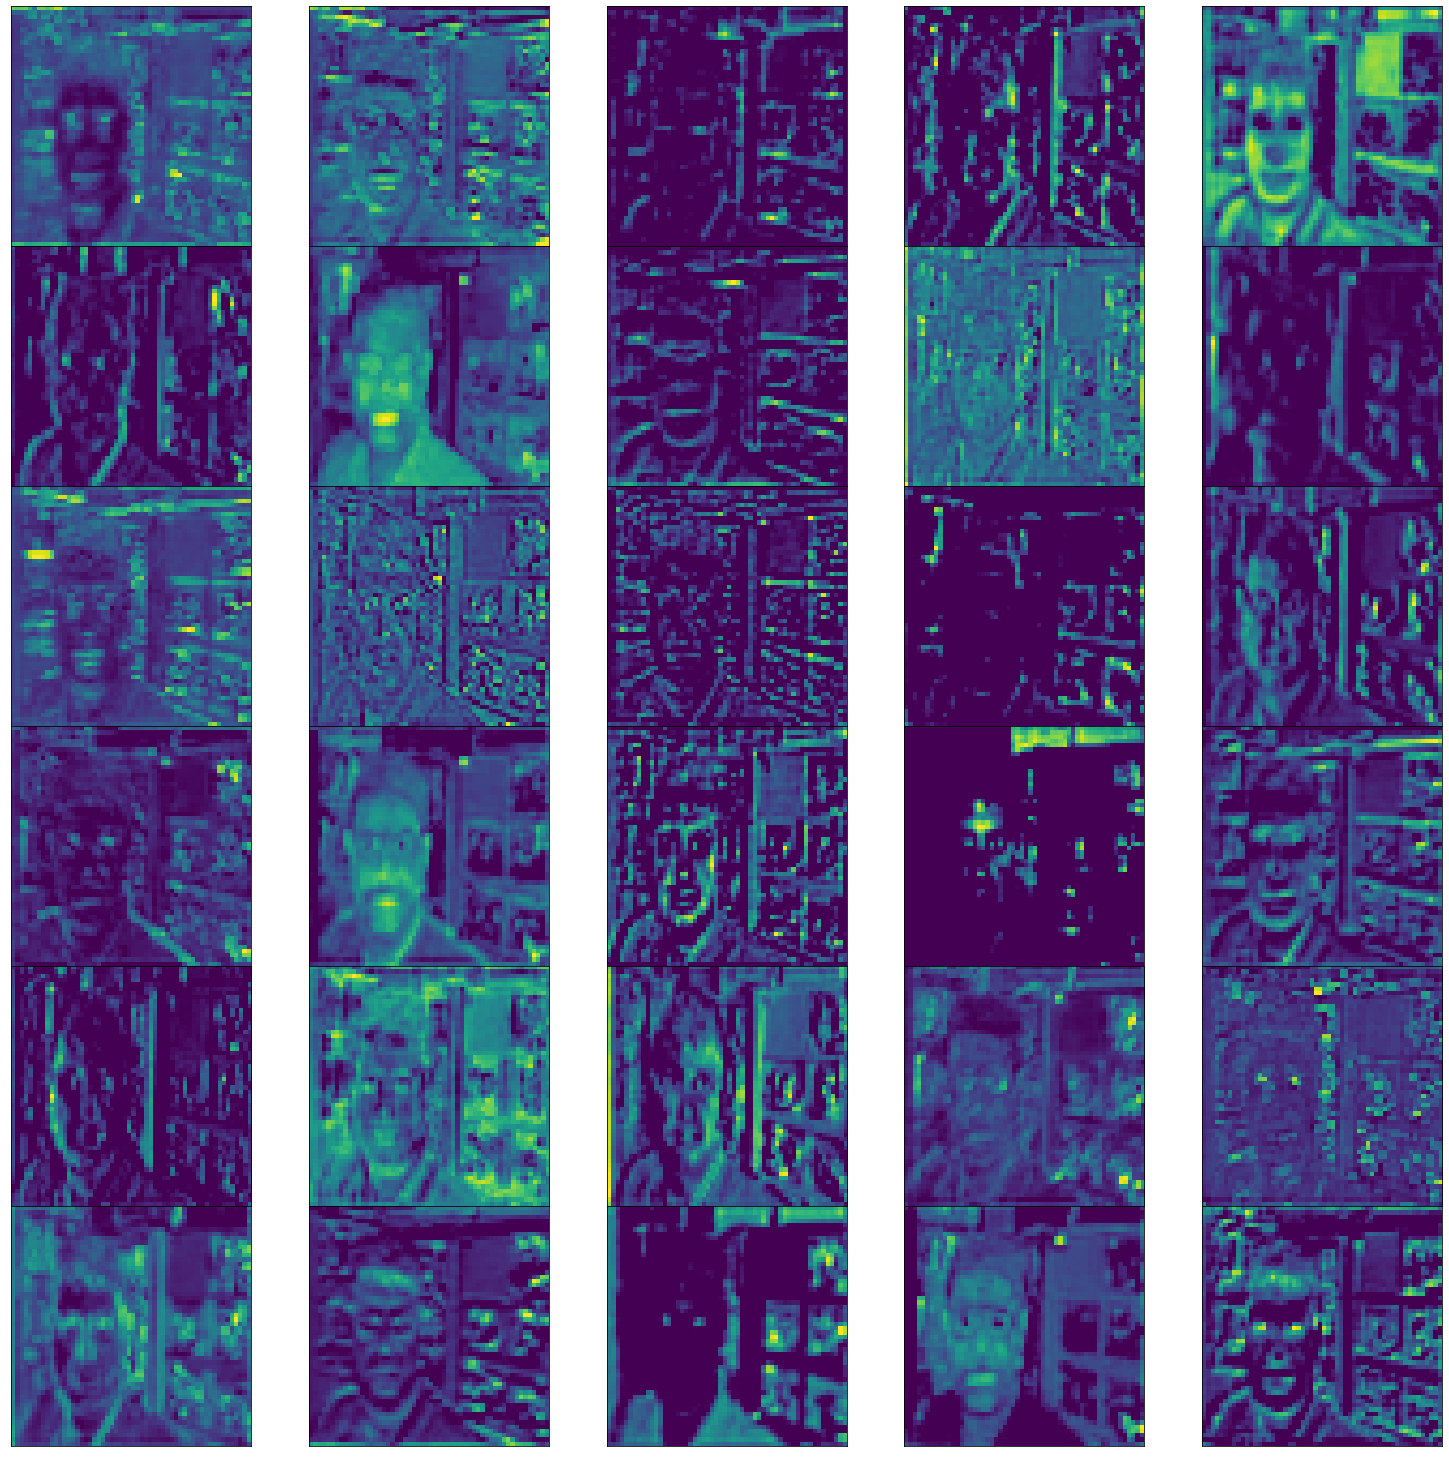

In [23]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.8, hspace=0, wspace=0.2)

for i in range(30):
    ax = fig.add_subplot(12, 5, i+1, xticks=[], yticks=[])
    ax.imshow(act[0][i])

- Output from the first BasicBlock of layer1

In [24]:
conv_out = LayerActivations(resnet.layer4,1)
o = resnet(Variable(img.cuda()))
conv_out.remove()
act = conv_out.features

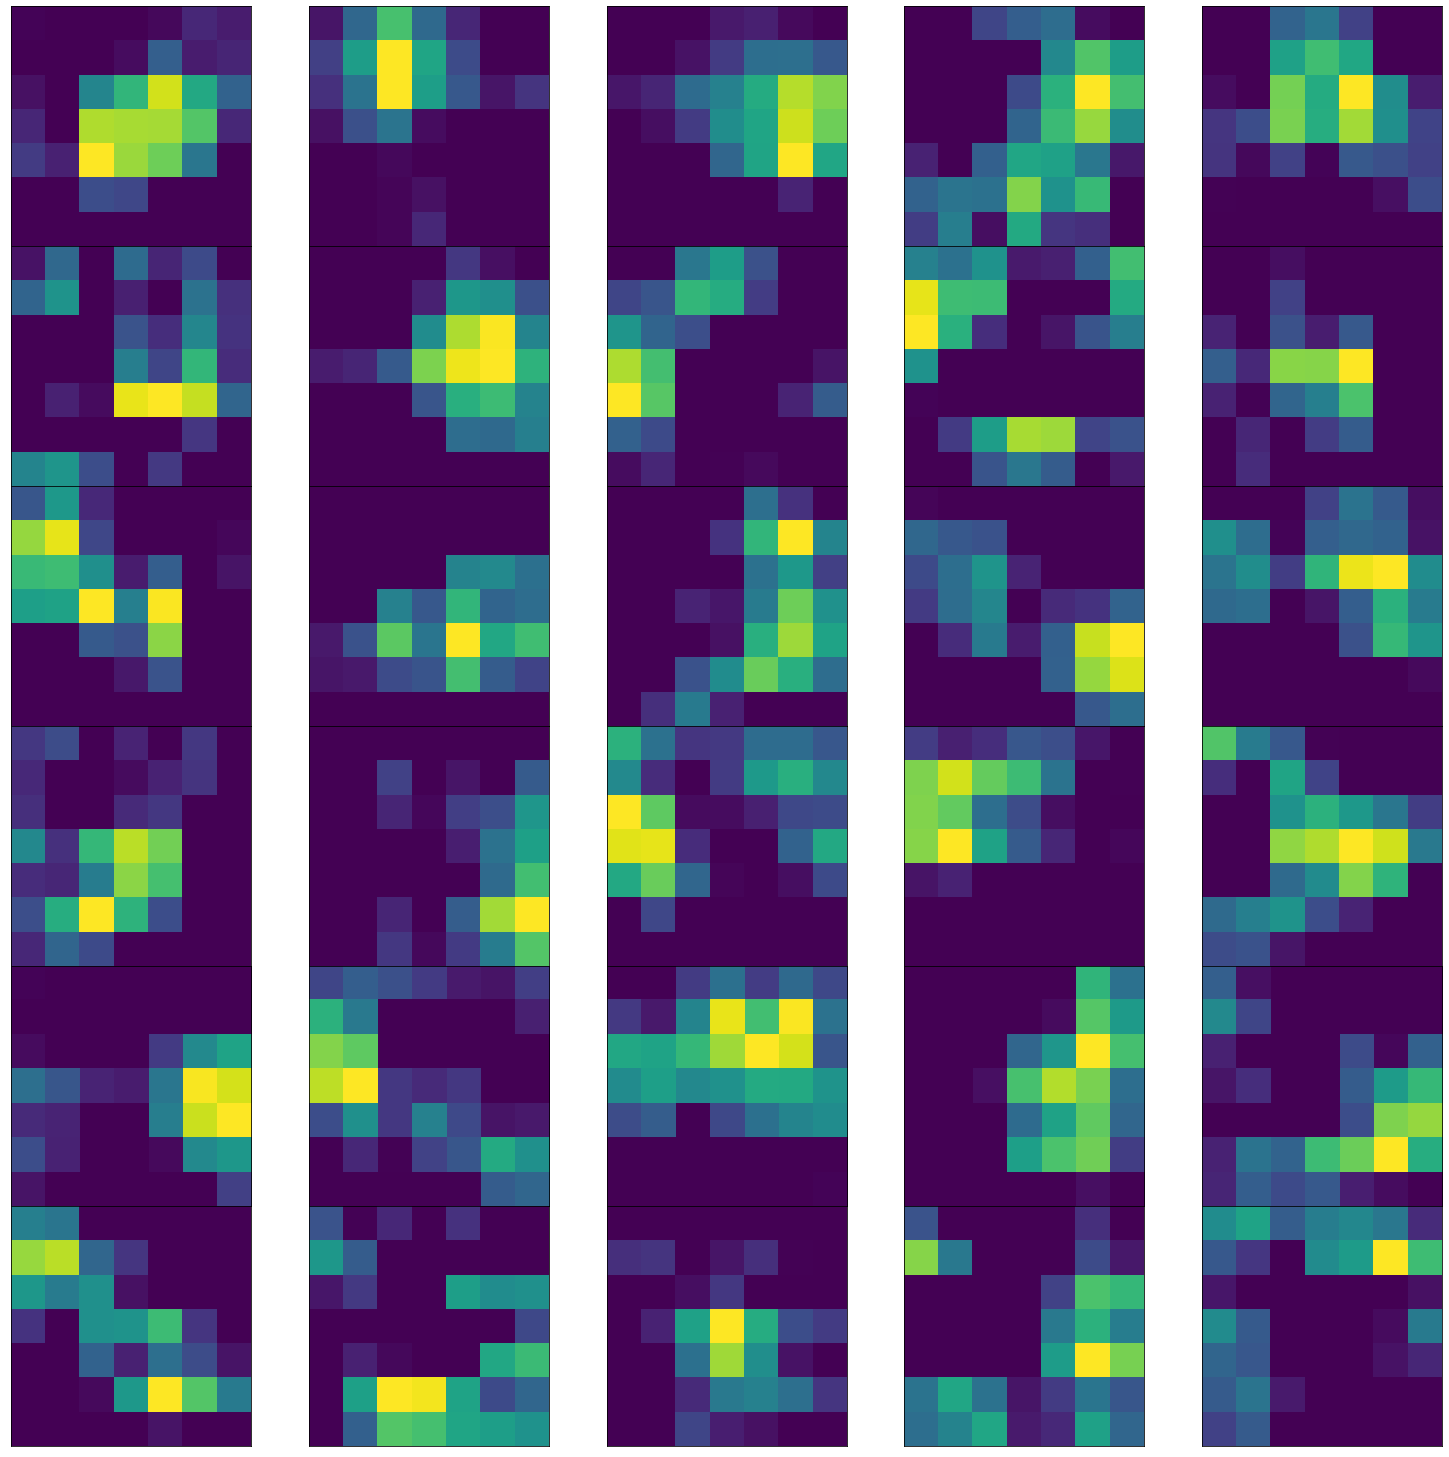

In [25]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.8, hspace=0, wspace=0.2)

for i in range(30):
    ax = fig.add_subplot(12, 5, i+1, xticks=[], yticks=[])
    ax.imshow(act[0][i])

- Output from the second BasicBlock of layer4

## Visualizing weight from intermediate layer

In [26]:
resnet.state_dict().keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [27]:
cnn_weights = resnet.state_dict()['conv1.weight'].cpu()

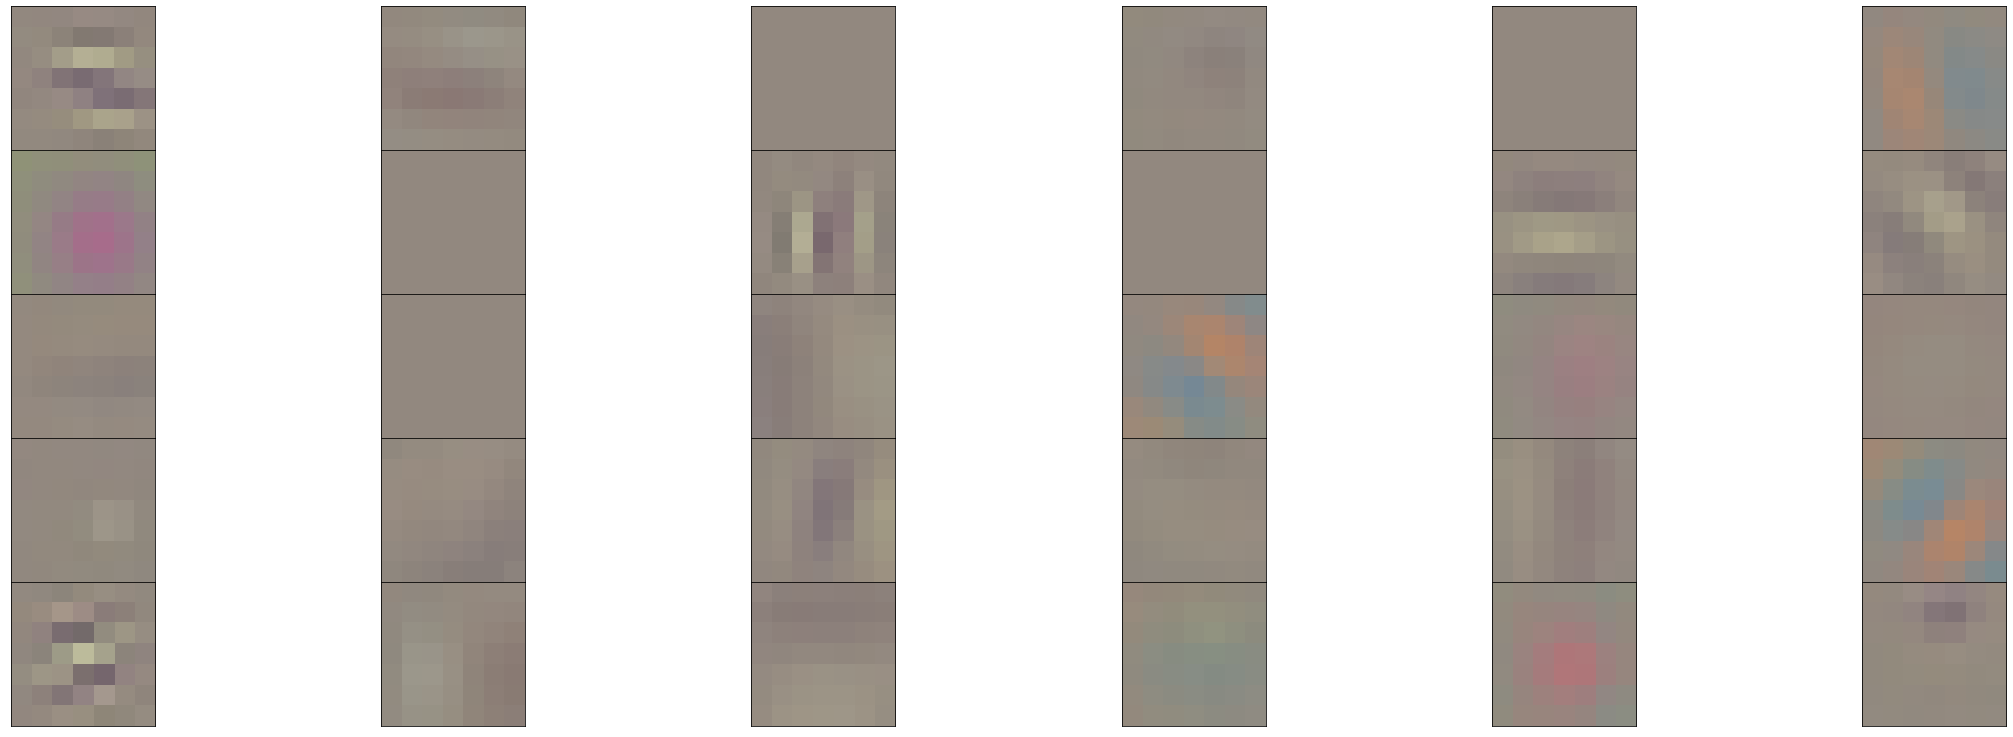

In [28]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.8, hspace=0, wspace=0.2)

for i in range(30):
    ax = fig.add_subplot(12, 6, i+1, xticks=[], yticks=[])
    imshow(cnn_weights[i])

In [29]:
cnn_weights.shape

torch.Size([64, 3, 7, 7])